In [3]:
# Cell 1: Config & tự tạo train_small.txt nếu cần

from pathlib import Path
import torch
import random

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# === PATH: chỉnh đúng với máy bạn ===
DATA_ROOT    = Path(r"D:\HUS_22001541\AdvancedCV\Project\data\processed\2d")
LABELED_ROOT = DATA_ROOT / "labeled"

CONFIG_DIR        = Path(r"D:\HUS_22001541\AdvancedCV\Project\config")
BASE_TRAIN_FILE   = CONFIG_DIR / "train.txt"
VAL_SPLIT_FILE    = CONFIG_DIR / "val.txt"
TEST_SPLIT_FILE   = CONFIG_DIR / "test.txt"

# === TỐI ƯU TỐC ĐỘ (bạn có thể chỉnh) ===
USE_SMALL_TRAIN   = True          # 💡 True: dùng tập train nhỏ, False: dùng full train
N_TRAIN_BRAINS    = 120           # 💡 số ca dùng cho train_small (từ 369 ca)
SLICE_STRIDE_TRAIN = 2            # 💡 lấy cách lát, 2 = dùng mỗi lát thứ 2; 1 = dùng tất cả
SLICE_STRIDE_EVAL  = 1            # val/test dùng toàn bộ lát để đánh giá đúng đề

# Huấn luyện
BATCH_SIZE  = 8                   # giữ 8 là ổn, nếu lỗi bộ nhớ có thể giảm 4
NUM_EPOCHS  = 15                  # 💡 15 epoch để chạy vừa phải; sau này muốn có thể tăng
LR          = 1e-4

CONFIG_DIR.mkdir(parents=True, exist_ok=True)

# === Tạo train_small.txt nếu cần ===
if USE_SMALL_TRAIN:
    TRAIN_SPLIT_FILE = CONFIG_DIR / "train_small.txt"
    if not TRAIN_SPLIT_FILE.exists():
        with open(BASE_TRAIN_FILE, "r", encoding="utf-8") as f:
            brains = [line.strip() for line in f if line.strip()]
        print("Tổng số Brain trong train.txt:", len(brains))
        random.seed(42)
        random.shuffle(brains)
        brains_small = brains[:N_TRAIN_BRAINS]
        with open(TRAIN_SPLIT_FILE, "w", encoding="utf-8") as f:
            for bid in brains_small:
                f.write(bid + "\n")
        print("Đã tạo train_small.txt với", len(brains_small), "ca")
    else:
        print("Đã có train_small.txt, dùng lại.")
else:
    TRAIN_SPLIT_FILE = BASE_TRAIN_FILE

print("TRAIN_SPLIT_FILE:", TRAIN_SPLIT_FILE)
print("VAL_SPLIT_FILE:", VAL_SPLIT_FILE)
print("TEST_SPLIT_FILE:", TEST_SPLIT_FILE)


Using device: cuda
Đã có train_small.txt, dùng lại.
TRAIN_SPLIT_FILE: D:\HUS_22001541\AdvancedCV\Project\config\train_small.txt
VAL_SPLIT_FILE: D:\HUS_22001541\AdvancedCV\Project\config\val.txt
TEST_SPLIT_FILE: D:\HUS_22001541\AdvancedCV\Project\config\test.txt


In [4]:
# Cell 2: Metric functions (Dice, IoU, Hausdorff95)

import math
import numpy as np
from scipy.ndimage import distance_transform_edt, binary_erosion
import torch.nn.functional as F

def compute_dice_iou_per_channel(logits, targets, threshold=0.5, eps=1e-6):
    """
    logits, targets: (B, C, H, W)
    Trả về:
      dice_per_channel: (C,)
      iou_per_channel:  (C,)
    Cho 3 kênh: WT, TC, ET.
    """
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    targets = targets.float()

    B, C, H, W = preds.shape
    preds_flat   = preds.view(B, C, -1)
    targets_flat = targets.view(B, C, -1)

    intersection = (preds_flat * targets_flat).sum(dim=-1)   # (B, C)
    pred_sum   = preds_flat.sum(dim=-1)
    target_sum = targets_flat.sum(dim=-1)
    union = pred_sum + target_sum - intersection

    dice = (2.0 * intersection + eps) / (pred_sum + target_sum + eps)
    iou  = (intersection + eps) / (union + eps)

    mask_valid = (target_sum + pred_sum) > 0
    dice = torch.where(mask_valid, dice, torch.ones_like(dice))
    iou  = torch.where(mask_valid, iou,  torch.ones_like(iou))

    dice_per_channel = dice.mean(dim=0)  # (C,)
    iou_per_channel  = iou.mean(dim=0)
    return dice_per_channel, iou_per_channel


def hausdorff95_binary(mask_pred, mask_true):
    """
    mask_pred, mask_true: numpy array 2D (bool hoặc 0/1)
    Trả về Hausdorff distance 95% (pixel units).
    """
    mask_pred = mask_pred.astype(bool)
    mask_true = mask_true.astype(bool)

    if not mask_pred.any() and not mask_true.any():
        return 0.0
    if not mask_pred.any() or not mask_true.any():
        return 999.0

    footprint = np.ones((3, 3), dtype=bool)
    eroded_pred = binary_erosion(mask_pred, structure=footprint, border_value=0)
    eroded_true = binary_erosion(mask_true, structure=footprint, border_value=0)
    surface_pred = mask_pred ^ eroded_pred
    surface_true = mask_true ^ eroded_true

    if not surface_pred.any():
        surface_pred = mask_pred
    if not surface_true.any():
        surface_true = mask_true

    dist_true = distance_transform_edt(~surface_true)
    dists_pred_to_true = dist_true[surface_pred]

    dist_pred = distance_transform_edt(~surface_pred)
    dists_true_to_pred = dist_pred[surface_true]

    all_dists = np.concatenate([dists_pred_to_true, dists_true_to_pred])
    if all_dists.size == 0:
        return 0.0
    return float(np.percentile(all_dists, 95))


In [5]:
# Cell 3: Dataset BraTS 2D (4 modal -> 3 kênh mask WT/TC/ET) + slice_stride

from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch

class Brats2DSegDataset(Dataset):
    def __init__(self, labeled_root: Path, split_file: Path, slice_stride: int = 1):
        """
        labeled_root: thư mục .../processed/2d/labeled
        split_file: file txt mỗi dòng là Brain_XXX
        slice_stride: bước nhảy lát (1 = dùng tất cả; 2 = mỗi lát thứ 2, ...)
                      -> dùng stride cho train để giảm thời gian, val/test dùng 1.
        """
        self.labeled_root = Path(labeled_root)
        self.split_file   = Path(split_file)
        self.slice_stride = slice_stride
        self.brain_ids    = self._load_brain_ids(split_file)
        self.samples      = self._collect_samples()

    def _load_brain_ids(self, split_file: Path):
        with open(split_file, "r", encoding="utf-8") as f:
            ids = [line.strip() for line in f if line.strip()]
        return ids

    def _collect_samples(self):
        samples = []
        for bid in self.brain_ids:
            brain_dir = self.labeled_root / bid
            mask_dir  = brain_dir / "mask"
            if not mask_dir.exists():
                continue
            mask_files = sorted(mask_dir.glob("mask_*.png"))

            # áp dụng stride (ví dụ: 2 -> dùng mỗi lát thứ 2)
            mask_files = mask_files[::self.slice_stride]

            for mf in mask_files:
                k_str = mf.stem.split("_")[-1]  # ví dụ "000" từ "mask_000"
                sample = {
                    "brain_id": bid,
                    "slice_idx": k_str,
                    "flair": brain_dir / "flair" / f"flair_{k_str}.png",
                    "t1":    brain_dir / "t1"    / f"t1_{k_str}.png",
                    "t1ce":  brain_dir / "t1ce"  / f"t1ce_{k_str}.png",
                    "t2":    brain_dir / "t2"    / f"t2_{k_str}.png",
                    "mask":  mf,
                }
                samples.append(sample)

        print(f"Found {len(samples)} slices for split {self.split_file.name} "
              f"(slice_stride={self.slice_stride})")
        return samples

    def __len__(self):
        return len(self.samples)

    def _load_image_as_float(self, path: Path):
        arr = np.array(Image.open(path), dtype=np.float32)
        if arr.max() > 0:
            arr = arr / 255.0
        return arr

    def __getitem__(self, idx):
        s = self.samples[idx]
        flair = self._load_image_as_float(s["flair"])
        t1    = self._load_image_as_float(s["t1"])
        t1ce  = self._load_image_as_float(s["t1ce"])
        t2    = self._load_image_as_float(s["t2"])
        mask_raw = np.array(Image.open(s["mask"]), dtype=np.uint8)

        # Ảnh (4, H, W)
        img = np.stack([flair, t1, t1ce, t2], axis=0)

        # BraTS (sau preprocess): mask_raw = 0 (bg), 1 (NCR/NET), 2 (ED), 3 (ET)
        # WT = 1|2|3, TC = 1|3, ET = 3
        wt = (mask_raw > 0).astype(np.float32)
        tc = np.isin(mask_raw, [1, 3]).astype(np.float32)
        et = (mask_raw == 3).astype(np.float32)
        mask = np.stack([wt, tc, et], axis=0)  # (3, H, W)

        img_tensor  = torch.from_numpy(img).float()
        mask_tensor = torch.from_numpy(mask).float()
        return img_tensor, mask_tensor


In [6]:
# Cell 4: UNet 2D (4 in, 3 out) với base_ch nhỏ hơn cho nhanh

import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNet2D(nn.Module):
    def __init__(self, in_channels=4, num_classes=3, base_ch=32):
        """
        base_ch=32 thay vì 64 => mô hình nhẹ hơn ~4 lần so với 64.
        """
        super().__init__()
        # Encoder
        self.down1 = DoubleConv(in_channels, base_ch)          # 4 -> 32
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base_ch, base_ch * 2)          # 32 -> 64
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(base_ch * 2, base_ch * 4)      # 64 -> 128
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(base_ch * 4, base_ch * 8)      # 128 -> 256
        self.pool4 = nn.MaxPool2d(2)
        self.bottom = DoubleConv(base_ch * 8, base_ch * 16)    # 256 -> 512

        # Decoder
        self.up1 = nn.ConvTranspose2d(base_ch * 16, base_ch * 8, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(base_ch * 16, base_ch * 8)
        self.up2 = nn.ConvTranspose2d(base_ch * 8, base_ch * 4, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(base_ch * 8, base_ch * 4)
        self.up3 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(base_ch * 4, base_ch * 2)
        self.up4 = nn.ConvTranspose2d(base_ch * 2, base_ch, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(base_ch * 2, base_ch)

        self.out_conv = nn.Conv2d(base_ch, num_classes, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        d3 = self.down3(p2)
        p3 = self.pool3(d3)

        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        b = self.bottom(p4)

        u1 = self.up1(b)
        u1 = torch.cat([d4, u1], dim=1)
        u1 = self.conv1(u1)

        u2 = self.up2(u1)
        u2 = torch.cat([d3, u2], dim=1)
        u2 = self.conv2(u2)

        u3 = self.up3(u2)
        u3 = torch.cat([d2, u3], dim=1)
        u3 = self.conv3(u3)

        u4 = self.up4(u3)
        u4 = torch.cat([d1, u4], dim=1)
        u4 = self.conv4(u4)

        out = self.out_conv(u4)
        return out

model = UNet2D(in_channels=4, num_classes=3, base_ch=32).to(DEVICE)
print("Model params (M):", sum(p.numel() for p in model.parameters()) / 1e6)


Model params (M): 7.766339


In [7]:
# Cell 5: Loss functions (Dice + BCE)

class DiceLossMultiChannel(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()
        B, C, H, W = probs.shape
        probs   = probs.view(B, C, -1)
        targets = targets.view(B, C, -1)

        intersection = (probs * targets).sum(dim=-1)
        denom = probs.sum(dim=-1) + targets.sum(dim=-1)
        dice = (2.0 * intersection + self.eps) / (denom + self.eps)
        return 1.0 - dice.mean()


dice_loss_fn = DiceLossMultiChannel()
bce_loss_fn  = nn.BCEWithLogitsLoss()

def combined_loss(logits, targets, lambda_dice=1.0, lambda_bce=1.0):
    ld = dice_loss_fn(logits, targets)
    lb = bce_loss_fn(logits, targets)
    return lambda_dice * ld + lambda_bce * lb, ld, lb

print("Loss functions ready.")

Loss functions ready.


In [8]:
# Cell 6: DataLoader cho train / val / test

from torch.utils.data import DataLoader

train_dataset = Brats2DSegDataset(
    LABELED_ROOT, TRAIN_SPLIT_FILE, slice_stride=SLICE_STRIDE_TRAIN
)
val_dataset = Brats2DSegDataset(
    LABELED_ROOT, VAL_SPLIT_FILE, slice_stride=SLICE_STRIDE_EVAL
)
test_dataset = Brats2DSegDataset(
    LABELED_ROOT, TEST_SPLIT_FILE, slice_stride=SLICE_STRIDE_EVAL
)

pin_memory = True if DEVICE.type == "cuda" else False

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,       # Windows nên để 0 cho an toàn
    pin_memory=pin_memory,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=pin_memory,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=pin_memory,
)

print("Train/Val/Test sizes:", len(train_dataset), len(val_dataset), len(test_dataset))
print("ok")


Found 9360 slices for split train_small.txt (slice_stride=2)
Found 8525 slices for split val.txt (slice_stride=1)
Found 8680 slices for split test.txt (slice_stride=1)
Train/Val/Test sizes: 9360 8525 8680
ok


In [9]:
# Cell X: Kiểm tra kích thước output và đếm số tham số của UNet2D

import torch

# Giả sử input của bạn là (B, 4, H, W), ví dụ H = W = 240
dummy_input = torch.randn(1, 4, 256, 256).to(DEVICE)  # sửa 240 nếu ảnh bạn khác size

model.eval()
with torch.no_grad():
    dummy_output = model(dummy_input)

print("Input shape :", tuple(dummy_input.shape))
print("Output shape:", tuple(dummy_output.shape))

# Đếm số tham số
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print(f"Total params        : {total_params:,}")
print(f"Trainable params    : {trainable_params:,}")
print(f"Non-trainable params: {non_trainable_params:,}")

# (tuỳ chọn) ước lượng dung lượng model (float32 ~ 4 bytes/param)
model_size_mb = total_params * 4 / (1024**2)
print(f"~ Model size        : {model_size_mb:.2f} MB (float32)")


Input shape : (1, 4, 256, 256)
Output shape: (1, 3, 256, 256)
Total params        : 7,766,339
Trainable params    : 7,766,339
Non-trainable params: 0
~ Model size        : 29.63 MB (float32)


In [7]:
# Cell 7: Train + Validation (AMP) + lưu log CSV

import pandas as pd
from torch.cuda.amp import GradScaler, autocast

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scaler = GradScaler(enabled=(DEVICE.type == "cuda"))

def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    running_dice_loss = 0.0
    running_bce_loss  = 0.0
    running_dice_score = torch.zeros(3, device=DEVICE)
    running_iou_score  = torch.zeros(3, device=DEVICE)
    n_batches = 0

    for imgs, masks in loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()

        with autocast(enabled=scaler.is_enabled()):
            logits = model(imgs)
            loss, loss_dice, loss_bce = combined_loss(logits, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            dice_c, iou_c = compute_dice_iou_per_channel(logits, masks)
            running_loss      += loss.item()
            running_dice_loss += loss_dice.item()
            running_bce_loss  += loss_bce.item()
            running_dice_score += dice_c
            running_iou_score  += iou_c
            n_batches += 1

    epoch_loss      = running_loss      / max(1, n_batches)
    epoch_dice_loss = running_dice_loss / max(1, n_batches)
    epoch_bce_loss  = running_bce_loss  / max(1, n_batches)
    epoch_dice_score = (running_dice_score / max(1, n_batches)).detach().cpu().numpy()
    epoch_iou_score  = (running_iou_score  / max(1, n_batches)).detach().cpu().numpy()
    return epoch_loss, epoch_dice_loss, epoch_bce_loss, epoch_dice_score, epoch_iou_score


def eval_one_epoch(model, loader, epoch, split="Val"):
    model.eval()
    running_loss = 0.0
    running_dice_loss = 0.0
    running_bce_loss  = 0.0
    running_dice_score = torch.zeros(3, device=DEVICE)
    running_iou_score  = torch.zeros(3, device=DEVICE)
    n_batches = 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            masks = masks.to(DEVICE, non_blocking=True)

            logits = model(imgs)
            loss, loss_dice, loss_bce = combined_loss(logits, masks)
            dice_c, iou_c = compute_dice_iou_per_channel(logits, masks)

            running_loss      += loss.item()
            running_dice_loss += loss_dice.item()
            running_bce_loss  += loss_bce.item()
            running_dice_score += dice_c
            running_iou_score  += iou_c
            n_batches += 1

    epoch_loss      = running_loss      / max(1, n_batches)
    epoch_dice_loss = running_dice_loss / max(1, n_batches)
    epoch_bce_loss  = running_bce_loss  / max(1, n_batches)
    epoch_dice_score = (running_dice_score / max(1, n_batches)).detach().cpu().numpy()
    epoch_iou_score  = (running_iou_score  / max(1, n_batches)).detach().cpu().numpy()
    return epoch_loss, epoch_dice_loss, epoch_bce_loss, epoch_dice_score, epoch_iou_score


history = {
    "epoch": [],
    "train_loss": [], "train_dice_loss": [], "train_bce_loss": [],
    "val_loss": [],   "val_dice_loss": [],   "val_bce_loss": [],
    "train_dice_WT": [], "train_dice_TC": [], "train_dice_ET": [],
    "val_dice_WT": [],   "val_dice_TC": [],   "val_dice_ET": [],
    "train_iou_WT": [], "train_iou_TC": [], "train_iou_ET": [],
    "val_iou_WT": [],   "val_iou_TC": [],   "val_iou_ET": [],
}

best_val_dice = -1.0
best_model_path = "unet2d_brats20_best.pth"

for epoch in range(1, NUM_EPOCHS + 1):
    tr_loss, tr_dice_loss, tr_bce_loss, tr_dice_score, tr_iou_score = train_one_epoch(
        model, train_loader, optimizer, epoch
    )
    val_loss, val_dice_loss, val_bce_loss, val_dice_score, val_iou_score = eval_one_epoch(
        model, val_loader, epoch, split="Val"
    )

    print(f"Epoch: {epoch} / {NUM_EPOCHS}")
    print(
        f"Train loss: {tr_loss:.5f}, DiceLoss: {tr_dice_loss:.5f}, BCE: {tr_bce_loss:.5f} | "
        f"Val loss: {val_loss:.5f}, DiceLoss: {val_dice_loss:.5f}, BCE: {val_bce_loss:.5f}"
    )
    print(
        f"    Train Dice score WT/TC/ET: {tr_dice_score} | "
        f"Val Dice score WT/TC/ET: {val_dice_score}"
    )
    print(
        f"    Train IoU  score WT/TC/ET: {tr_iou_score} | "
        f"Val IoU  score WT/TC/ET: {val_iou_score}"
    )

    # Lưu history
    history["epoch"].append(epoch)
    history["train_loss"].append(float(tr_loss))
    history["train_dice_loss"].append(float(tr_dice_loss))
    history["train_bce_loss"].append(float(tr_bce_loss))
    history["val_loss"].append(float(val_loss))
    history["val_dice_loss"].append(float(val_dice_loss))
    history["val_bce_loss"].append(float(val_bce_loss))

    history["train_dice_WT"].append(float(tr_dice_score[0]))
    history["train_dice_TC"].append(float(tr_dice_score[1]))
    history["train_dice_ET"].append(float(tr_dice_score[2]))
    history["val_dice_WT"].append(float(val_dice_score[0]))
    history["val_dice_TC"].append(float(val_dice_score[1]))
    history["val_dice_ET"].append(float(val_dice_score[2]))

    history["train_iou_WT"].append(float(tr_iou_score[0]))
    history["train_iou_TC"].append(float(tr_iou_score[1]))
    history["train_iou_ET"].append(float(tr_iou_score[2]))
    history["val_iou_WT"].append(float(val_iou_score[0]))
    history["val_iou_TC"].append(float(val_iou_score[1]))
    history["val_iou_ET"].append(float(val_iou_score[2]))

    mean_val_dice_score = float(val_dice_score.mean())
    if mean_val_dice_score > best_val_dice:
        best_val_dice = mean_val_dice_score
        torch.save(model.state_dict(), best_model_path)
        print(f"  --> Saved new best model with mean Dice score={best_val_dice:.4f}")

df_log = pd.DataFrame(history)
df_log.to_csv("unet2d_brats20_training_log.csv", index=False)
print("Đã lưu log training vào unet2d_brats20_training_log.csv")


C:\Users\Admin\AppData\Local\Temp\ipykernel_21496\3505209381.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE.type == "cuda"))
C:\Users\Admin\AppData\Local\Temp\ipykernel_21496\3505209381.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler.is_enabled()):


Epoch: 1 / 15
Train loss: 1.25658, DiceLoss: 0.94721, BCE: 0.30937 | Val loss: 1.05929, DiceLoss: 0.92248, BCE: 0.13681
    Train Dice score WT/TC/ET: [0.69537127 0.6329759  0.44413018] | Val Dice score WT/TC/ET: [0.7726411  0.83822745 0.8400016 ]
    Train IoU  score WT/TC/ET: [0.6531684  0.60098064 0.41763532] | Val IoU  score WT/TC/ET: [0.73451656 0.8082678  0.81339777]
  --> Saved new best model with mean Dice score=0.8170
Epoch: 2 / 15
Train loss: 0.94115, DiceLoss: 0.86728, BCE: 0.07387 | Val loss: 0.88793, DiceLoss: 0.84405, BCE: 0.04388
    Train Dice score WT/TC/ET: [0.7634541 0.781983  0.7749181] | Val Dice score WT/TC/ET: [0.78565186 0.81027377 0.80422854]
    Train IoU  score WT/TC/ET: [0.7249776  0.7510566  0.74712753] | Val IoU  score WT/TC/ET: [0.7504383 0.7778868 0.7775063]
Epoch: 3 / 15
Train loss: 0.82862, DiceLoss: 0.80321, BCE: 0.02541 | Val loss: 0.82403, DiceLoss: 0.80312, BCE: 0.02091
    Train Dice score WT/TC/ET: [0.7638409  0.8017995  0.78867656] | Val Dice sc

In [10]:
# Cell 8: Demo inference 1 sample từ val_dataset + overlay mask lên ảnh gốc
# - Load best model
# - Predict cho 1 slice
# - Lưu ảnh input + mask GT + mask Pred + overlay màu ra PNG
# - Tính Dice / IoU cho từng kênh (WT, TC, ET) của sample đó

import torch
import numpy as np
from pathlib import Path
from PIL import Image

# ===== 0. Chọn thiết bị infer (dùng CPU cho an toàn) =====
DEVICE_INFER = torch.device("cpu")
print("DEVICE_INFER:", DEVICE_INFER)

# ===== 1. Khởi tạo model và load weight tốt nhất =====
best_model_path = "unet2d_brats20_best.pth"  # đổi nếu bạn lưu tên khác

model_infer = UNet2D(
    in_channels=4,   # 4 modality: FLAIR, T1, T1ce, T2
    num_classes=3,   # 3 kênh: WT, TC, ET
    base_ch=32
).to(DEVICE_INFER)

print("Loading state_dict...")
state_dict = torch.load(best_model_path, map_location=DEVICE_INFER)
model_infer.load_state_dict(state_dict)
model_infer.eval()

print(f"Loaded best model from: {best_model_path}")
print("Model ready for inference.")

# ===== 2. Lấy ngẫu nhiên 1 sample từ val_dataset =====
dataset_for_demo = val_dataset   # hoặc test_dataset nếu muốn

print("Dataset length:", len(dataset_for_demo))
idx = np.random.randint(0, len(dataset_for_demo))
print("Sampling index:", idx)

sample = dataset_for_demo[idx]
print("Sample type:", type(sample))

# Dataset trả về tuple (img, mask)
if isinstance(sample, dict):
    img = sample["image"]   # (4,H,W)
    mask = sample["mask"]   # (3,H,W)
else:
    img, mask = sample

print("Image shape (tensor):", img.shape)
print("Mask shape (tensor):", mask.shape)

# ===== 3. Forward qua model =====
img_tensor = img.unsqueeze(0).to(DEVICE_INFER)  # (1,4,H,W)
print("Image batch shape:", img_tensor.shape)

with torch.no_grad():
    print("Running forward pass...")
    logits = model_infer(img_tensor)           # (1,3,H,W)
    print("Logits shape:", logits.shape)
    probs  = torch.sigmoid(logits)             # (1,3,H,W)
    pred_mask = (probs > 0.5).float()          # (1,3,H,W) nhị phân

print("Predicted mask shape (batch):", pred_mask.shape)

# ===== 4. Đưa về numpy =====
img_np       = img.cpu().numpy()                    # (4,H,W)
mask_gt_np   = mask.cpu().numpy()                   # (3,H,W)
mask_pred_np = pred_mask.squeeze(0).cpu().numpy()   # (3,H,W)

print("Image numpy shape:", img_np.shape)
print("GT mask numpy shape:", mask_gt_np.shape)
print("Pred mask numpy shape:", mask_pred_np.shape)

# ===== 5. Chọn modality hiển thị & chuẩn hóa về [0,255] =====

# img_np shape: (4, H, W)  -> 4 modal
modalities = img_np

# Tính variance mỗi modal, chọn modal có var lớn nhất (ít "đen xì" nhất)
vars_ = [m.var() for m in modalities]
best_mod = int(np.argmax(vars_))
print("Var từng modal:", vars_, "-> chọn modal", best_mod)

img_show = modalities[best_mod]   # (H, W) 1 kênh

img_min = img_show.min()
img_max = img_show.max()
print(f"Base image min={img_min:.4f}, max={img_max:.4f}")

if img_max - img_min < 1e-8:
    print("⚠ Cảnh báo: slice này gần như toàn 0, nên nhìn sẽ rất đen (data gốc).")

# Chuẩn hóa về [0,1] rồi thành [0,255] uint8
img_norm = (img_show - img_min) / (img_max - img_min + 1e-8)
img_uint8 = (img_norm * 255).astype(np.uint8)

out_dir = Path("demo_test")
out_dir.mkdir(exist_ok=True)
print("Saving outputs to:", out_dir.resolve())

Image.fromarray(img_uint8).save(out_dir / f"case_{idx}_input_mod{best_mod}.png")

# ===== 6. Lưu mask GT & Pred nhị phân từng kênh (WT/TC/ET) =====

def save_mask(mask_2d, path):
    m = (mask_2d > 0).astype(np.uint8) * 255  # 0 hoặc 255
    Image.fromarray(m).save(path)

names = ["WT", "TC", "ET"]
for c, name in enumerate(names):
    gt_path   = out_dir / f"case_{idx}_GT_{name}.png"
    pred_path = out_dir / f"case_{idx}_Pred_{name}.png"
    save_mask(mask_gt_np[c], gt_path)
    save_mask(mask_pred_np[c], pred_path)

print("Đã lưu:")
print(f" - {out_dir / f'case_{idx}_input_mod{best_mod}.png'}")
for name in names:
    print(f" - {out_dir / f'case_{idx}_GT_{name}.png'}")
    print(f" - {out_dir / f'case_{idx}_Pred_{name}.png'}")

# ===== 7. Overlay màu lên ảnh gốc =====

# Chuyển base image xám sang RGB float32
base_rgb = np.stack([img_uint8]*3, axis=-1).astype(np.float32)  # (H,W,3)

color_map = {
    "WT": np.array([255,   0,   0], dtype=np.float32),  # đỏ
    "TC": np.array([  0, 255,   0], dtype=np.float32),  # xanh lá
    "ET": np.array([  0,   0, 255], dtype=np.float32),  # xanh dương
}
alpha = 0.4

# --- Overlay Prediction ---
overlay_pred = base_rgb.copy()
for c, name in enumerate(names):
    mask_c = (mask_pred_np[c] > 0.5)        # bool (H,W)
    color  = color_map[name].reshape(1,1,3) # (1,1,3) để broadcast
    overlay_pred[mask_c] = overlay_pred[mask_c] * (1 - alpha) + color * alpha

overlay_pred_uint8 = np.clip(overlay_pred, 0, 255).astype(np.uint8)
Image.fromarray(overlay_pred_uint8).save(out_dir / f"case_{idx}_overlay_pred.png")

# --- Overlay Ground Truth (optional) ---
overlay_gt = base_rgb.copy()
for c, name in enumerate(names):
    mask_c = (mask_gt_np[c] > 0.5)
    color  = color_map[name].reshape(1,1,3)
    overlay_gt[mask_c] = overlay_gt[mask_c] * (1 - alpha) + color * alpha

overlay_gt_uint8 = np.clip(overlay_gt, 0, 255).astype(np.uint8)
Image.fromarray(overlay_gt_uint8).save(out_dir / f"case_{idx}_overlay_gt.png")

print("Đã lưu thêm:")
print(f" - {out_dir / f'case_{idx}_overlay_pred.png'}")
print(f" - {out_dir / f'case_{idx}_overlay_gt.png'}")



DEVICE_INFER: cpu
Loading state_dict...
Loaded best model from: unet2d_brats20_best.pth
Model ready for inference.
Dataset length: 8525
Sampling index: 2228
Sample type: <class 'tuple'>
Image shape (tensor): torch.Size([4, 256, 256])
Mask shape (tensor): torch.Size([3, 256, 256])
Image batch shape: torch.Size([1, 4, 256, 256])
Running forward pass...
Logits shape: torch.Size([1, 3, 256, 256])
Predicted mask shape (batch): torch.Size([1, 3, 256, 256])
Image numpy shape: (4, 256, 256)
GT mask numpy shape: (3, 256, 256)
Pred mask numpy shape: (3, 256, 256)
Var từng modal: [np.float32(0.035045978), np.float32(0.080864266), np.float32(0.04841522), np.float32(0.017301157)] -> chọn modal 1
Base image min=0.0000, max=1.0000
Saving outputs to: D:\HUS_22001541\AdvancedCV\Project\notebooks\demo_test
Đã lưu:
 - demo_test\case_2228_input_mod1.png
 - demo_test\case_2228_GT_WT.png
 - demo_test\case_2228_Pred_WT.png
 - demo_test\case_2228_GT_TC.png
 - demo_test\case_2228_Pred_TC.png
 - demo_test\case_

In [8]:
# Cell 9: Evaluate toàn bộ test_loader
# - Load best model
# - Chạy qua test_loader
# - Tính Dice / IoU trung bình cho WT, TC, ET và mean

import torch
import numpy as np

# Dùng DEVICE gốc của bạn (thường là cuda nếu có), nếu sợ OOM thì chuyển thành cpu
try:
    DEVICE_EVAL = DEVICE
except NameError:
    DEVICE_EVAL = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("DEVICE_EVAL:", DEVICE_EVAL)

best_model_path = "unet2d_brats20_best.pth"

model_eval = UNet2D(
    in_channels=4,
    num_classes=3,
    base_ch=32
).to(DEVICE_EVAL)

print("Loading state_dict for eval...")
state_dict = torch.load(best_model_path, map_location=DEVICE_EVAL)
model_eval.load_state_dict(state_dict)
model_eval.eval()

names = ["WT", "TC", "ET"]
num_classes = 3

# Các biến tích lũy cho toàn bộ test set
intersection_sum = np.zeros(num_classes, dtype=np.float64)
pred_sum         = np.zeros(num_classes, dtype=np.float64)
gt_sum           = np.zeros(num_classes, dtype=np.float64)

@torch.no_grad()
def accumulate_metrics_batch(logits, target, threshold=0.5):
    """
    logits: (B,3,H,W)
    target: (B,3,H,W), 0/1
    Cộng dồn intersection, pred_sum, gt_sum cho toàn batch (toàn C).
    """
    probs = torch.sigmoid(logits)              # (B,3,H,W)
    preds = (probs > threshold).float()        # (B,3,H,W)
    target = target.float()                    # (B,3,H,W)

    # chuyển sang CPU để tính bằng numpy cho chắc
    preds_np  = preds.cpu().numpy()
    target_np = target.cpu().numpy()

    B, C, H, W = preds_np.shape
    inter = (preds_np * target_np).sum(axis=(0, 2, 3))      # (C,)
    p_sum = preds_np.sum(axis=(0, 2, 3))                    # (C,)
    g_sum = target_np.sum(axis=(0, 2, 3))                   # (C,)

    return inter, p_sum, g_sum

print("Bắt đầu evaluate trên test_loader...")

for batch_idx, (images, masks) in enumerate(test_loader):
    images = images.to(DEVICE_EVAL)   # (B,4,H,W)
    masks  = masks.to(DEVICE_EVAL)    # (B,3,H,W)

    logits = model_eval(images)       # (B,3,H,W)

    inter, p_sum, g_sum = accumulate_metrics_batch(logits, masks)

    intersection_sum += inter
    pred_sum         += p_sum
    gt_sum           += g_sum

    if (batch_idx + 1) % 10 == 0:
        print(f"  Processed {batch_idx+1} batches...")

eps = 1e-7
dice_scores = np.zeros(num_classes, dtype=np.float64)
iou_scores  = np.zeros(num_classes, dtype=np.float64)

for c in range(num_classes):
    inter_c = intersection_sum[c]
    p_c     = pred_sum[c]
    g_c     = gt_sum[c]

    dice_scores[c] = (2.0 * inter_c + eps) / (p_c + g_c + eps)
    iou_scores[c]  = (inter_c + eps) / (p_c + g_c - inter_c + eps)

print("\n=== Test set metrics (global over all pixels) ===")
for c, name in enumerate(names):
    print(f"{name}: Dice = {dice_scores[c]:.4f}, IoU = {iou_scores[c]:.4f}")

mean_dice = dice_scores.mean()
mean_iou  = iou_scores.mean()
print(f"\nMean Dice (WT/TC/ET): {mean_dice:.4f}")
print(f"Mean IoU  (WT/TC/ET): {mean_iou:.4f}")


DEVICE_EVAL: cuda
Loading state_dict for eval...
Bắt đầu evaluate trên test_loader...
  Processed 10 batches...
  Processed 20 batches...
  Processed 30 batches...
  Processed 40 batches...
  Processed 50 batches...
  Processed 60 batches...
  Processed 70 batches...
  Processed 80 batches...
  Processed 90 batches...
  Processed 100 batches...
  Processed 110 batches...
  Processed 120 batches...
  Processed 130 batches...
  Processed 140 batches...
  Processed 150 batches...
  Processed 160 batches...
  Processed 170 batches...
  Processed 180 batches...
  Processed 190 batches...
  Processed 200 batches...
  Processed 210 batches...
  Processed 220 batches...
  Processed 230 batches...
  Processed 240 batches...
  Processed 250 batches...
  Processed 260 batches...
  Processed 270 batches...
  Processed 280 batches...
  Processed 290 batches...
  Processed 300 batches...
  Processed 310 batches...
  Processed 320 batches...
  Processed 330 batches...
  Processed 340 batches...
  Pro

In [12]:
print("GT sum per class [WT, TC, ET]:", gt_sum)
print("Pred sum per class [WT, TC, ET]:", pred_sum)


GT sum per class [WT, TC, ET]: 1229.0
Pred sum per class [WT, TC, ET]: 1758.0


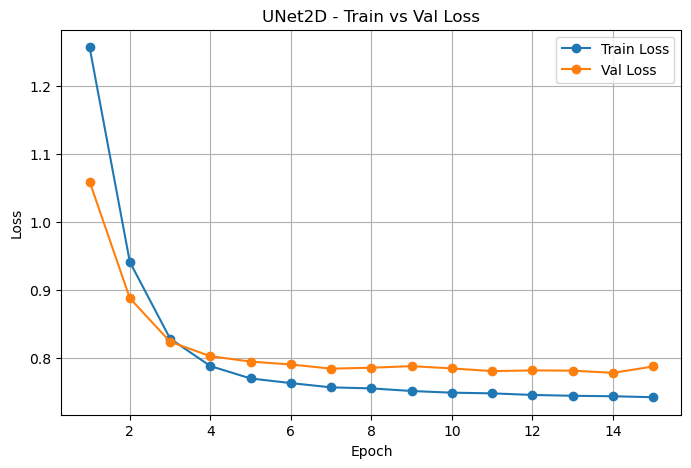

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = r"D:\HUS_22001541\AdvancedCV\Project\notebooks\unet2d_brats20_training_log.csv"
df = pd.read_csv(log_path)

plt.figure(figsize=(8, 5))
plt.plot(df["epoch"], df["train_loss"], marker="o", label="Train Loss")
plt.plot(df["epoch"], df["val_loss"], marker="o", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("UNet2D - Train vs Val Loss")
plt.legend()
plt.grid(True)
plt.show()


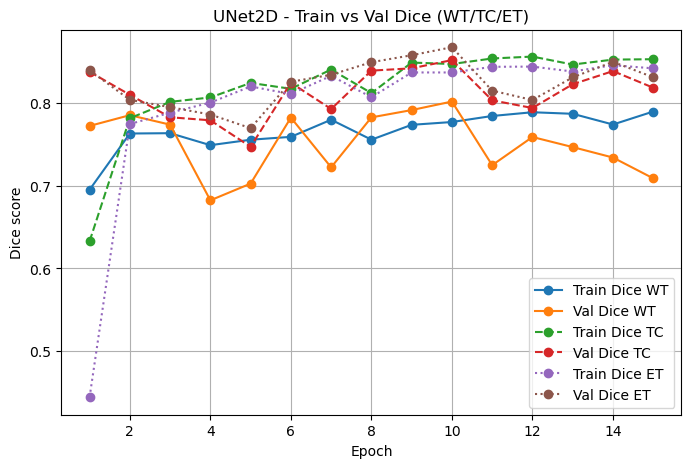

In [2]:
plt.figure(figsize=(8, 5))
plt.plot(df["epoch"], df["train_dice_WT"], marker="o", label="Train Dice WT")
plt.plot(df["epoch"], df["val_dice_WT"], marker="o", label="Val Dice WT")
plt.plot(df["epoch"], df["train_dice_TC"], marker="o", label="Train Dice TC", linestyle="--")
plt.plot(df["epoch"], df["val_dice_TC"], marker="o", label="Val Dice TC", linestyle="--")
plt.plot(df["epoch"], df["train_dice_ET"], marker="o", label="Train Dice ET", linestyle=":")
plt.plot(df["epoch"], df["val_dice_ET"], marker="o", label="Val Dice ET", linestyle=":")
plt.xlabel("Epoch")
plt.ylabel("Dice score")
plt.title("UNet2D - Train vs Val Dice (WT/TC/ET)")
plt.legend()
plt.grid(True)
plt.show()


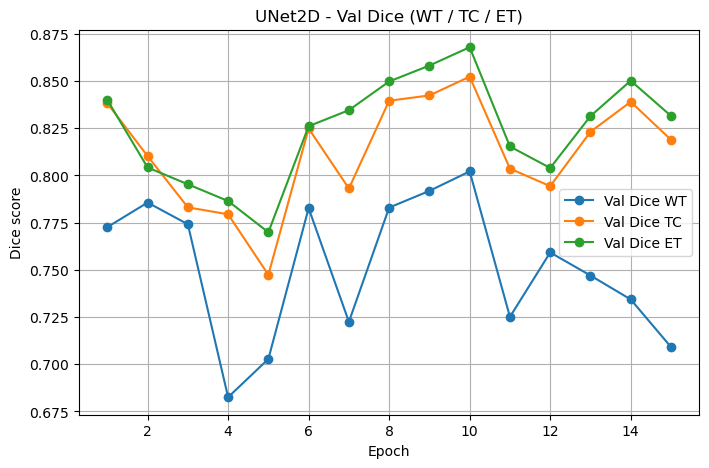

In [3]:
plt.figure(figsize=(8, 5))
plt.plot(df["epoch"], df["val_dice_WT"], marker="o", label="Val Dice WT")
plt.plot(df["epoch"], df["val_dice_TC"], marker="o", label="Val Dice TC")
plt.plot(df["epoch"], df["val_dice_ET"], marker="o", label="Val Dice ET")
plt.xlabel("Epoch")
plt.ylabel("Dice score")
plt.title("UNet2D - Val Dice (WT / TC / ET)")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Cell X: Visualize a few test slices with overlay_gt & overlay_pred (no saving)

import torch
import numpy as np
import matplotlib.pyplot as plt

# Dùng cùng device với phần trên
DEVICE_EVAL = DEVICE

# 1. Load best model
best_model_path = "unet2d_brats20_best.pth"  # nhớ đúng tên file bạn đã lưu
model_eval = UNet2D(in_channels=4, num_classes=3, base_ch=32).to(DEVICE_EVAL)
state_dict = torch.load(best_model_path, map_location=DEVICE_EVAL)
model_eval.load_state_dict(state_dict)
model_eval.eval()

print("Loaded best model from:", best_model_path)

names = ["WT", "TC", "ET"]
color_map = {
    "WT": np.array([255,   0,   0], dtype=np.float32),  # đỏ
    "TC": np.array([  0, 255,   0], dtype=np.float32),  # xanh lá
    "ET": np.array([  0,   0, 255], dtype=np.float32),  # xanh dương
}
alpha = 0.4  # độ trong suốt của mask

# 2. Chọn ngẫu nhiên vài index từ test_dataset
N_SAMPLES = 3  # muốn nhiều hơn thì tăng lên
indices = np.random.choice(len(test_dataset), size=N_SAMPLES, replace=False)
print("Test indices:", indices)

for idx in indices:
    # ----- Lấy dữ liệu -----
    img, mask = test_dataset[idx]   # img: (4,H,W), mask: (3,H,W)
    img_np       = img.numpy()
    mask_gt_np   = mask.numpy()

    # ----- Chạy model -----
    img_tensor = img.unsqueeze(0).to(DEVICE_EVAL)  # (1,4,H,W)
    with torch.no_grad():
        logits = model_eval(img_tensor)            # (1,3,H,W)
        probs  = torch.sigmoid(logits)
        pred_mask = (probs > 0.5).float()          # (1,3,H,W)

    mask_pred_np = pred_mask.squeeze(0).cpu().numpy()  # (3,H,W)

    # ----- Chọn modality sáng nhất làm nền -----
    vars_ = [m.var() for m in img_np]  # var từng modal
    best_mod = int(np.argmax(vars_))
    img_show = img_np[best_mod]        # (H,W)

    img_min = img_show.min()
    img_max = img_show.max()
    if img_max - img_min < 1e-8:
        print(f"[idx={idx}] ⚠ slice gần như toàn 0, ảnh sẽ khá tối.")

    img_norm  = (img_show - img_min) / (img_max - img_min + 1e-8)
    img_uint8 = (img_norm * 255).astype(np.uint8)

    # ----- Tạo overlay GT & Pred -----
    base_rgb = np.stack([img_uint8]*3, axis=-1).astype(np.float32)  # (H,W,3)

    # Overlay GT
    overlay_gt = base_rgb.copy()
    for c, name in enumerate(names):
        mask_c = (mask_gt_np[c] > 0.5)
        color  = color_map[name].reshape(1, 1, 3)
        overlay_gt[mask_c] = overlay_gt[mask_c] * (1 - alpha) + color * alpha
    overlay_gt_uint8 = np.clip(overlay_gt, 0, 255).astype(np.uint8)

    # Overlay Pred
    overlay_pred = base_rgb.copy()
    for c, name in enumerate(names):
        mask_c = (mask_pred_np[c] > 0.5)
        color  = color_map[name].reshape(1, 1, 3)
        overlay_pred[mask_c] = overlay_pred[mask_c] * (1 - alpha) + color * alpha
    overlay_pred_uint8 = np.clip(overlay_pred, 0, 255).astype(np.uint8)

    # ----- Hiển thị -----
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Test sample idx={idx} (mod {best_mod}, var={vars_[best_mod]:.4f})", fontsize=12)

    axes[0].imshow(overlay_gt_uint8)
    axes[0].set_title("Overlay GT")
    axes[0].axis("off")

    axes[1].imshow(overlay_pred_uint8)
    axes[1].set_title("Overlay Pred")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


Loaded best model from: unet2d_brats20_best.pth
Test indices: [1128 6520 7503]


: 

DEVICE_INFER: cpu
Loading state_dict...
Loaded best model from: unet2d_brats20_best.pth
Model ready for inference.
Dataset length (test): 8680
Sampling index from test_dataset: 3484
Sample type: <class 'tuple'>
Image shape (tensor): torch.Size([4, 256, 256])
Mask shape (tensor): torch.Size([3, 256, 256])
Image batch shape: torch.Size([1, 4, 256, 256])
Running forward pass...
Logits shape: torch.Size([1, 3, 256, 256])
Predicted mask shape (batch): torch.Size([1, 3, 256, 256])
Image numpy shape: (4, 256, 256)
GT mask numpy shape: (3, 256, 256)
Pred mask numpy shape: (3, 256, 256)
Var từng modal: [np.float32(0.09876312), np.float32(0.13972569), np.float32(0.09197548), np.float32(0.058239512)] -> chọn modal 1
Base image min=0.0000, max=1.0000

=== Sample test idx=3484, modality 1 ===
Trái: Input | Giữa: Overlay GT | Phải: Overlay Pred


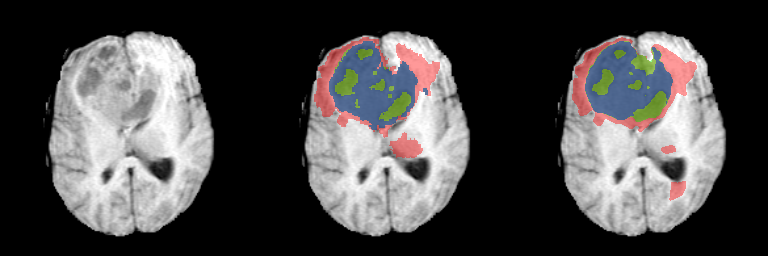

In [184]:
# Cell 8: Demo inference 1 sample từ test_dataset + show overlay (không lưu file)

import torch
import numpy as np
from PIL import Image
from IPython.display import display

# ===== 0. Chọn thiết bị infer (CPU cho an toàn) =====
DEVICE_INFER = torch.device("cpu")
print("DEVICE_INFER:", DEVICE_INFER)

# ===== 1. Khởi tạo model và load weight tốt nhất =====
best_model_path = "unet2d_brats20_best.pth"  # nhớ đúng tên

model_infer = UNet2D(
    in_channels=4,   # 4 modality: FLAIR, T1, T1ce, T2
    num_classes=3,   # 3 kênh: WT, TC, ET
    base_ch=32
).to(DEVICE_INFER)

print("Loading state_dict...")
state_dict = torch.load(best_model_path, map_location=DEVICE_INFER)
model_infer.load_state_dict(state_dict)
model_infer.eval()

print(f"Loaded best model from: {best_model_path}")
print("Model ready for inference.")

# ===== 2. Lấy ngẫu nhiên 1 sample từ test_dataset =====
dataset_for_demo = test_dataset   # 🔥 dùng test.txt

print("Dataset length (test):", len(dataset_for_demo))
idx = np.random.randint(0, len(dataset_for_demo))
print("Sampling index from test_dataset:", idx)

sample = dataset_for_demo[idx]
print("Sample type:", type(sample))

# Dataset trả về tuple (img, mask)
if isinstance(sample, dict):
    img = sample["image"]   # (4,H,W)
    mask = sample["mask"]   # (3,H,W)
else:
    img, mask = sample

print("Image shape (tensor):", img.shape)
print("Mask shape (tensor):", mask.shape)

# ===== 3. Forward qua model =====
img_tensor = img.unsqueeze(0).to(DEVICE_INFER)  # (1,4,H,W)
print("Image batch shape:", img_tensor.shape)

with torch.no_grad():
    print("Running forward pass...")
    logits = model_infer(img_tensor)           # (1,3,H,W)
    print("Logits shape:", logits.shape)
    probs  = torch.sigmoid(logits)             # (1,3,H,W)
    pred_mask = (probs > 0.5).float()          # (1,3,H,W) nhị phân

print("Predicted mask shape (batch):", pred_mask.shape)

# ===== 4. Đưa về numpy =====
img_np       = img.cpu().numpy()                    # (4,H,W)
mask_gt_np   = mask.cpu().numpy()                   # (3,H,W)
mask_pred_np = pred_mask.squeeze(0).cpu().numpy()   # (3,H,W)

print("Image numpy shape:", img_np.shape)
print("GT mask numpy shape:", mask_gt_np.shape)
print("Pred mask numpy shape:", mask_pred_np.shape)

# ===== 5. Chọn modality hiển thị & chuẩn hóa về [0,255] =====

modalities = img_np   # (4,H,W)

# Tính variance mỗi modal, chọn modal có var lớn nhất (ít "đen xì" nhất)
vars_ = [m.var() for m in modalities]
best_mod = int(np.argmax(vars_))
print("Var từng modal:", vars_, "-> chọn modal", best_mod)

img_show = modalities[best_mod]   # (H, W) 1 kênh

img_min = img_show.min()
img_max = img_show.max()
print(f"Base image min={img_min:.4f}, max={img_max:.4f}")

if img_max - img_min < 1e-8:
    print("⚠ Cảnh báo: slice này gần như toàn 0, nên nhìn sẽ rất đen (data gốc).")

# Chuẩn hóa về [0,1] rồi thành [0,255] uint8
img_norm  = (img_show - img_min) / (img_max - img_min + 1e-8)
img_uint8 = (img_norm * 255).astype(np.uint8)

# ===== 6. Tạo overlay màu lên ảnh gốc (GT & Pred) =====

names = ["WT", "TC", "ET"]
color_map = {
    "WT": np.array([255,   0,   0], dtype=np.float32),  # đỏ
    "TC": np.array([  0, 255,   0], dtype=np.float32),  # xanh lá
    "ET": np.array([  0,   0, 255], dtype=np.float32),  # xanh dương
}
alpha = 0.4

# Base RGB
base_rgb = np.stack([img_uint8]*3, axis=-1).astype(np.float32)  # (H,W,3)

# Overlay GT
overlay_gt = base_rgb.copy()
for c, name in enumerate(names):
    mask_c = (mask_gt_np[c] > 0.5)
    color  = color_map[name].reshape(1, 1, 3)
    overlay_gt[mask_c] = overlay_gt[mask_c] * (1 - alpha) + color * alpha
overlay_gt_uint8 = np.clip(overlay_gt, 0, 255).astype(np.uint8)

# Overlay Pred
overlay_pred = base_rgb.copy()
for c, name in enumerate(names):
    mask_c = (mask_pred_np[c] > 0.5)
    color  = color_map[name].reshape(1, 1, 3)
    overlay_pred[mask_c] = overlay_pred[mask_c] * (1 - alpha) + color * alpha
overlay_pred_uint8 = np.clip(overlay_pred, 0, 255).astype(np.uint8)

# ===== 7. Ghép 3 ảnh trên cùng 1 hàng và hiển thị =====

from IPython.display import display

# input đang là ảnh xám (H,W), cần đổi sang RGB (H,W,3) để ghép cho đẹp
input_rgb = np.stack([img_uint8]*3, axis=-1).astype(np.uint8)  # (H,W,3)

# Đảm bảo overlay_* đã là uint8 3 kênh
overlay_gt_rgb   = overlay_gt_uint8.astype(np.uint8)    # (H,W,3)
overlay_pred_rgb = overlay_pred_uint8.astype(np.uint8)  # (H,W,3)

# Ghép ngang: [Input | Overlay GT | Overlay Pred]
combined = np.concatenate(
    [input_rgb, overlay_gt_rgb, overlay_pred_rgb],
    axis=1  # ghép theo chiều rộng
)  # shape: (H, W*3, 3)

print(f"\n=== Sample test idx={idx}, modality {best_mod} ===")
print("Trái: Input | Giữa: Overlay GT | Phải: Overlay Pred")
display(Image.fromarray(combined))



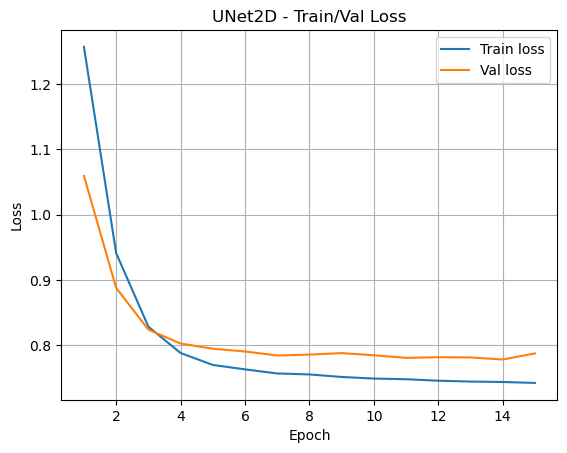

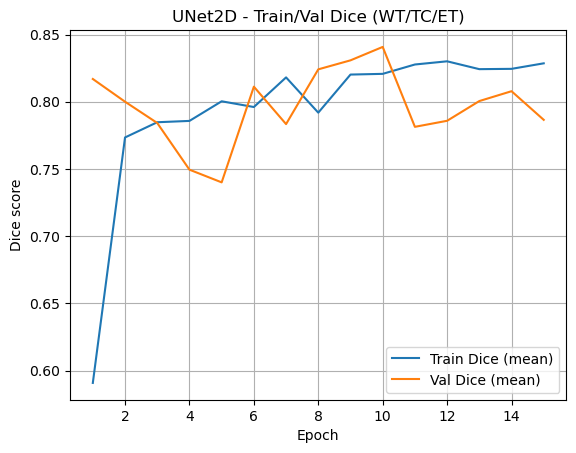

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("unet2d_brats20_training_log.csv")

# Biểu đồ loss
plt.figure()
plt.plot(df["epoch"], df["train_loss"], label="Train loss")
plt.plot(df["epoch"], df["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("UNet2D - Train/Val Loss")
plt.grid(True)
plt.savefig("UNet2D_Loss_Curves.png", dpi=300, bbox_inches="tight")

# Biểu đồ Dice (mean 3 kênh WT/TC/ET)
train_dice_mean = df[["train_dice_WT", "train_dice_TC", "train_dice_ET"]].mean(axis=1)
val_dice_mean   = df[["val_dice_WT", "val_dice_TC", "val_dice_ET"]].mean(axis=1)

plt.figure()
plt.plot(df["epoch"], train_dice_mean, label="Train Dice (mean)")
plt.plot(df["epoch"], val_dice_mean, label="Val Dice (mean)")
plt.xlabel("Epoch")
plt.ylabel("Dice score")
plt.legend()
plt.title("UNet2D - Train/Val Dice (WT/TC/ET)")
plt.grid(True)
plt.savefig("UNet2D_Dice_Curves.png", dpi=300, bbox_inches="tight")
